In [18]:
#%matplotlib notebook
import sys
import os
import glob

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from bundle_adjust import ba_timeseries
import pickle

# Display and interface settings (just for the notebook interface)
%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Check std single date (in the overlapping areas)

In [7]:
scene_name = 'RB_ZAF_0001'
ba_method = 'sequential'

timeline_ids = ['s4_20190608T075318Z__s4_20190608T075352Z__s4_20190608T075428Z',
                's4_20190617T075138Z__s4_20190617T075212Z__s4_20190617T075248Z',
                's103_20190627T074821Z__s103_20190627T074854Z__s103_20190627T074931Z',
                's106_20190629T104731Z__s106_20190629T104805Z__s106_20190629T104841Z',
                's107_20190630T104349Z__s107_20190630T104424Z__s107_20190630T104459Z']
                

for t_id in timeline_ids:
    wdir = 'exp/{}/4D_ba_{}/warp/{}'.format(scene_name, ba_method, t_id)
    fnames = glob.glob('{}/**/*.tif'.format(wdir), recursive=True)

    stacked_warps = np.dstack([np.array(Image.open(fn)) for fn in fnames])
    out_fn = 'exp/{}/4D_ba_{}/4Dstats/std_per_date/{}.tif'.format(scene_name, ba_method, t_id)
    os.makedirs(os.path.dirname(out_fn), exist_ok=True)
    Image.fromarray(np.nanstd(stacked_warps, axis=2)).save(out_fn)
    #fig = plt.figure(figsize=(30,15))
    #plt.imshow(np.nanstd(stacked_warps, axis=2));


/home/rogermm14/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


### Check std along time

In [12]:
from PIL import Image

scene_name = 'RB_ZAF_0001'

ba_methods = ['sequential', 'global'] #['global', 'sequential', 'out-of-core']

std_after_ba = [np.array(Image.open('exp/{}/4D_ba_{}/4Dstats/std.tif'.format(scene_name, k))) for k in ba_methods]

for idx, method in enumerate(ba_methods):
    print(method, 'method', np.nanmedian(std_after_ba[idx], axis=(0, 1)))

sequential method 0.66272104
global method 0.72571474


/home/rogermm14/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


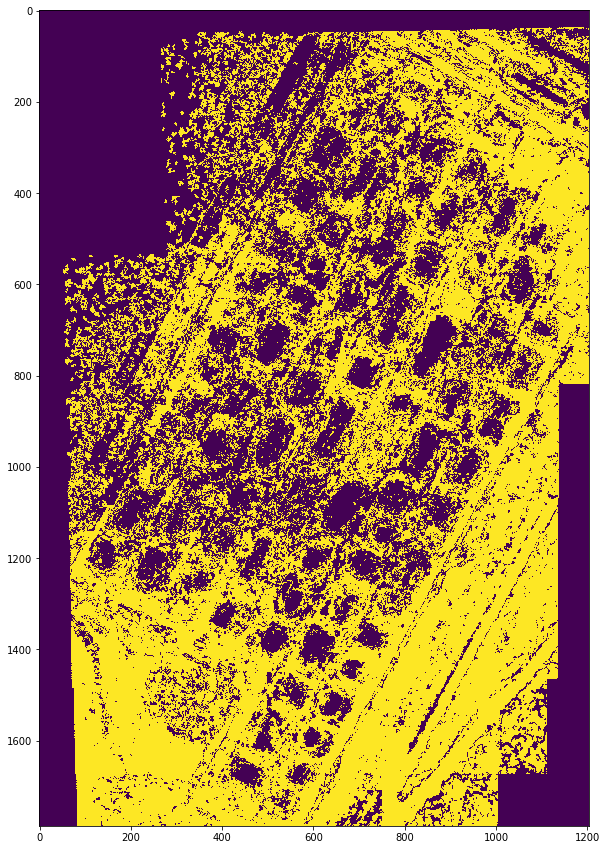

In [68]:
fig = plt.figure(figsize=(30,15))

plt.imshow(std_after_ba[0]< 1.0);

### Check reprojection error

In [46]:
# load scene and timeline indices

scene_name = 'RB_ZAF_0001'

input_dir = '/home/carlo/dsms-timeseries-for-roger'
output_dir = 'exp'

scene = ba_timeseries.Scene(input_dir, output_dir, scene_name, 'v1', \
                            compute_aoi_masks=True, use_aoi_masks_to_equalize_crops=False)
#scene.display_aoi()

source_dsms_dir = '{}/{}_dsms'.format(scene.src_dir, scene_name)
example_dsm_fname = os.path.join(source_dsms_dir, \
                                 's103_20190627T074821Z__s103_20190627T074854Z__s103_20190627T074931Z.tiff')
scene.characterize_from_example_dsm(example_dsm_fname)
#scene.display_dsm_mask()

timeline_indices = [0, 3, 6, 7, 8] # 0, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16 contain no errors

scene.get_timeline_attributes(timeline_indices, ['datetime', 'n_images'])

#############################################################
Loading scene RB_ZAF_0001...

Found 85 different dates in the scene timeline

Total images in timeline: 560
Successfully loaded scene RB_ZAF_0001
#############################################################


Scene RB_ZAF_0001 characterized using the following example dsm:
/home/carlo/dsms-timeseries-for-roger/RB_ZAF_0001/RB_ZAF_0001_dsms/s103_20190627T074821Z__s103_20190627T074854Z__s103_20190627T074931Z.tiff

index  |  datetime             |  n_images
__________________________________________

0      |  2019-06-08 07:53:52  |  5       
3      |  2019-06-17 07:51:38  |  9       
6      |  2019-06-27 07:48:21  |  7       
7      |  2019-06-29 10:47:31  |  8       
8      |  2019-06-30 10:44:24  |  4       
__________________________________________

                                  33 total




In [57]:
def eval_reprojection_error_from_rpcs(scene, myimages, ba_method, C, pairs_to_triangulate):
    
    # load filenames and rpcs
    rpcs_init_dir = '{}/RPC_init'.format(scene.dst_dir)
    rpcs_init = ba_timeseries.load_rpcs_from_dir(myimages, rpcs_init_dir, suffix='RPC', verbose=True)
    rpcs_adj_dir = '{}/ba_{}/RPC_adj'.format(scene.dst_dir, ba_method)
    rpcs_adj = ba_timeseries.load_rpcs_from_dir(myimages, rpcs_adj_dir, suffix='RPC_adj', verbose=True)
    
    # load image crops
    mycrops = ba_timeseries.load_image_crops(myimages, verbose=True)
    
    # init ba
    cam_model = 'Perspective'
    ba_input_data = {}
    ba_input_data['input_dir'] = scene.dst_dir
    ba_input_data['output_dir'] = scene.dst_dir
    ba_input_data['n_new'] = len(myimages)
    ba_input_data['n_adj'] = 0
    ba_input_data['image_fnames'] = myimages
    ba_input_data['crops'] = mycrops
    ba_input_data['masks'] = None
    ba_input_data['rpcs'] = rpcs_init
    ba_input_data['cam_model'] = cam_model
    ba_input_data['aoi'] = scene.aoi_lonlat
    from bundle_adjust.ba_pipeline import BundleAdjustmentPipeline
    ba_pipeline = BundleAdjustmentPipeline(ba_input_data)
    
    # approximate rpcs as proj matrices
    from bundle_adjust.ba_core import approximate_rpcs_as_proj_matrices
    P_crop_ba = approximate_rpcs_as_proj_matrices(rpcs_adj, mycrops, scene.aoi_lonlat, cam_model)
    ba_pipeline.P_crop_ba = P_crop_ba
        
    # init pts 3D
    from bundle_adjust.ba_triangulation import initialize_3d_points
    pts_3d = initialize_3d_points(ba_pipeline.input_P, C, pairs_to_triangulate, cam_model)
    pts_3d_ba = initialize_3d_points(P_crop_ba, C, pairs_to_triangulate, cam_model)
        
    # compute reprojection error
    ba_pipeline.pts_3d = pts_3d
    ba_pipeline.pts_3d_ba = pts_3d_ba
    ba_pipeline.C = C
    avg_init, avg_ba = [], []
    for im_idx in range(len(myimages)):
        e_init, e_ba = ba_pipeline.compute_reproj_err_per_image(im_idx)
        avg_init.append(np.mean(e_init))
        avg_ba.append(np.mean(e_ba))
        
        print('{:02}: avg init err {:.3f}, avg ba err {:.3f}'.format(im_idx, avg_init[-1], avg_ba[-1]))
        
    
    print('\nMethod: {} bundle adjustment'.format(ba_method))
    print('-----------------------------------------------------------------')
    print('\navg init err per image: {:.3f}'.format(np.mean(avg_init)))
    print('\navg ba err per image: {:.3f}'.format(np.mean(avg_ba)))

In [58]:
ba_method = 'out-of-core'

pickle_in = open('{}/ba_{}/matches.pickle'.format(scene.dst_dir, ba_method),'rb')
pairwise_matches = pickle.load(pickle_in)
pickle_in = open('{}/ba_{}/pairs_triangulation.pickle'.format(scene.dst_dir, ba_method),'rb')
pairs_to_triangulate = pickle.load(pickle_in)
pickle_in = open('{}/ba_{}/filenames.pickle'.format(scene.dst_dir, ba_method),'rb')
myimages = pickle.load(pickle_in)

features = []
for fn in myimages:
    f_id = os.path.splitext(os.path.basename(fn))[0]
    features.append(pickle.load(open('{}/ba_{}/features/{}.pickle'.format(scene.dst_dir, ba_method, f_id),'rb')))
    
from feature_tracks.ft_utils import feature_tracks_from_pairwise_matches
C = feature_tracks_from_pairwise_matches(features, pairwise_matches, pairs_to_triangulate)

print('Using {} feature tracks\n'.format(C.shape))

C.shape before baseline check (66, 8462)
C.shape after baseline check (66, 5730)
Using (66, 5730) feature tracks



In [59]:
eval_reprojection_error_from_rpcs(scene, myimages, ba_method, C, pairs_to_triangulate)

Loading 33 image rpcs / 33
Done!

Loading 33 image rpcs / 33
Done!

Loading 33 image crops / 33
Done!

Approximating RPCs as Perspective projection matrices
33 projection matrices / 33 (0 err)
Done!

Approximating RPCs as Perspective projection matrices
33 projection matrices / 33 (0 err)
Done!

00: avg init err 0.793, avg ba err 0.925
01: avg init err 2.201, avg ba err 11.480
02: avg init err 5.622, avg ba err 3.461
03: avg init err 4.487, avg ba err 2.409
04: avg init err 0.600, avg ba err 2.448
05: avg init err 1.048, avg ba err 0.691
06: avg init err 1.383, avg ba err 1.405
07: avg init err 1.755, avg ba err 3.962
08: avg init err 1.049, avg ba err 1.452
09: avg init err 0.883, avg ba err 10.459
10: avg init err 0.757, avg ba err 1.114
11: avg init err 0.619, avg ba err 0.463
12: avg init err 0.849, avg ba err 6.092
13: avg init err 0.944, avg ba err 0.427
14: avg init err 1.340, avg ba err 3.475
15: avg init err 1.313, avg ba err 3.787
16: avg init err 1.193, avg ba err 6.997
17: 